<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/Tabular_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#package for the data profiling
%%capture
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
#package for encoding categorical predictors
%%capture
pip install category_encoders

In [ ]:
from pandas_profiling import ProfileReport

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Prep

In [3]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving nomad.csv to nomad.csv


In [4]:
# Load Dataframe Dataframe 
df = pd.read_csv('nomad.csv')
df.head(3)

,User ID,User Registered Date,User Num References,User Num Qualified References,User Num Completed PCLs,User Num State Licenses,User Has Compact License (Yes / No),User Count Applications Completed last 7 Days,User Count Applications Completed last 30 Days,User Count Applications Completed,"User Count Jobs Viewed, last 30 Days",User Certifications,User EHR Systems,User Specialization List,User Age Bucket,User Years Nursing Exp,User Years Travel Exp,User First Application Date,User Last Application Date,User Count Offered
0,5f75431f88dc8fa23a15ba1c,2020-09-30,3,2,1,1,Yes,0.0,0.0,1.0,18,ACLS-BLS,Epic-Matrix AOD,"Medical Surgical - Telemetry, Medical-Surgical",35-39,11.0,0.0,2020-10-01,2020-10-01,1
1,5f75395acc3fc01efb9224c7,2020-09-30,3,2,1,1,Yes,0.0,0.0,1.0,1,ACLS,Cerner-Meditech-Soarian,"Medical Surgical - Telemetry, Long Term Care",40s,6.0,0.0,2020-10-07,2020-10-07,0
2,5f751230008c3f36cc830320,2020-09-30,4,3,3,2,Yes,0.0,0.0,6.0,0,ACLS-BLS-NIHSS,Cerner-Epic-HMS-Meditech,"Cardiac ICU, Telemetry, Critical Care, Medical...",35-39,14.0,3.0,2020-09-30,2020-10-14,0


In [ ]:
 #Dataframe Stats
 print(f'df.shape - {df.shape}')
 df.describe()

In [6]:
# Basic Data Quality Check
df.isnull().sum()

User  ID                                            0
User Registered Date                                0
User Num References                                 0
User Num Qualified References                       0
User Num Completed PCLs                             0
User Num State Licenses                             0
User Has Compact License (Yes / No)                 0
User Count Applications Completed last 7 Days     179
User Count Applications Completed last 30 Days    179
User Count Applications Completed                 179
User Count Jobs Viewed, last 30 Days                0
User Certifications                                 9
User EHR Systems                                   22
User Specialization List                          376
User Age Bucket                                     0
User Years Nursing Exp                            115
User Years Travel Exp                             564
User First Application Date                       180
User Last Application Date  

In [7]:
# I made a decion to drop all rows with NaN values since it is unclear how to impute those 
df_cleaned = df.dropna()
df_cleaned.shape

(3761, 20)

In [ ]:
# Data Profiling for the Exploration
profile = ProfileReport(df_cleaned, title='Data Profiling Report', html={'style':{'full_width':False}})

In [ ]:
profile.to_notebook_iframe()

In [ ]:
df_cleaned.columns #service code to get a list of column, delete before deployment

Index(['User  ID', 'User Registered Date', 'User Num References',
       'User Num Qualified References', 'User Num Completed PCLs',
       'User Num State Licenses', 'User Has Compact License (Yes / No)',
       'User Count Applications Completed last 7 Days',
       'User Count Applications Completed last 30 Days',
       'User Count Applications Completed',
       'User Count Jobs Viewed, last 30 Days', 'User Certifications',
       'User EHR Systems', 'User Specialization List', 'User Age Bucket',
       'User Years Nursing Exp', 'User Years Travel Exp',
       'User First Application Date', 'User Last Application Date',
       'User Count Offered'],
      dtype='object')

In [8]:
# Dataframe of Original Numeric Predictors (dropping all categorical data & target for follow-up processing):
X_original = df_cleaned.drop(['User  ID', 'User Registered Date','User Has Compact License (Yes / No)','User Certifications', 
                              'User EHR Systems','User Specialization List','User Age Bucket', 'User First Application Date', 
                              'User Last Application Date','User Count Offered' ], axis=1) 

In [9]:
X_original.shape

(3761, 10)

In [10]:
#Target Dataframe:
Y = df_cleaned['User Count Offered']

In [11]:
#SERVICE CODE TO BE DELETED
df_cleaned = df_cleaned.drop(['User  ID', 'User Registered Date'], axis=1)
df_cleaned.shape 

(3761, 18)

In [12]:
# transforming categorical data
# conversion to dummies for low cardinality variables
df_to_dummies = df_cleaned['User Has Compact License (Yes / No)']
df_dummies = pd.get_dummies(df_to_dummies, columns=['User Has Compact License (Yes / No)'])
# conversion to hashes for high cordinality variables
# default settings are used. Depending the realtive business importance of these parameters it may be refined further during feature engineering 
df_to_hush_transform = df_cleaned[['User Certifications', 'User EHR Systems','User Specialization List']]
hash_encoder = ce.HashingEncoder()
df_hash_encoded = hash_encoder.fit_transform(df_to_hush_transform)

In [13]:
# new numeric parameters frame
df_new_variables = pd.concat([df_hash_encoded,df_dummies],axis=1)

In [14]:
# Dataframe of Predictors:
X = pd.concat([X_original,df_new_variables], axis=1)

In [17]:
X.head(3)
# col_0 through Col_7 are the result of hashing 'User Certifications', 'User EHR Systems' and 'User Specialization List'
# categorical series, those parameters can not be interpreted independentaly, these are embeddings via hashing
# this element of data paremetrization should be researched further as a part of the feature engineering for the any model 
# planned for Prod

,User Num References,User Num Qualified References,User Num Completed PCLs,User Num State Licenses,User Count Applications Completed last 7 Days,User Count Applications Completed last 30 Days,User Count Applications Completed,"User Count Jobs Viewed, last 30 Days",User Years Nursing Exp,User Years Travel Exp,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,No,Yes
0,3,2,1,1,0.0,0.0,1.0,18,11.0,0.0,1,1,0,0,0,0,0,1,0,1
1,3,2,1,1,0.0,0.0,1.0,1,6.0,0.0,0,1,0,0,0,0,2,0,0,1
2,4,3,3,2,0.0,0.0,6.0,0,14.0,3.0,2,1,0,0,0,0,0,0,0,1


In [37]:
# Predictors variables to Numpy arrays following by scaling
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.05, random_state=42)
# Using Standard Scaler
scaler = StandardScaler().fit(X.values)
X_train_rescaled = scaler.transform(X_train)
X_test_rescaled = scaler.transform(X_test)

In [38]:
X_test_rescaled

array([[-0.62838288, -0.87692182, -0.92948719, ..., -0.76460892,
        -0.42917823,  0.42917823],
       [ 0.1143412 ,  0.72799446,  0.47079373, ..., -0.76460892,
        -0.42917823,  0.42917823],
       [-0.62838288, -0.07446368, -0.22934673, ...,  2.57146317,
        -0.42917823,  0.42917823],
       ...,
       [-0.62838288, -0.07446368,  1.1709342 , ..., -0.76460892,
         2.3300343 , -2.3300343 ],
       [ 0.1143412 ,  0.72799446,  0.47079373, ..., -0.76460892,
        -0.42917823,  0.42917823],
       [-0.62838288, -0.87692182, -0.22934673, ..., -0.76460892,
        -0.42917823,  0.42917823]])

**Data Prep Findings**


*   The Target - 'User Count Offered' appears to  have only 2 classes [0,1].  Therefore the below model is a binary classifier.  It won't be difficult to change it to the multi-class  
*   The following data series are excluded from the model parameters: 'User  ID', 'User Registered Date' (for obvious reasons, these 2 shouldn't affect the result), 'User Age Bucket' (I hope it doesn't affect the result. if it does,  there is an age-bias in this industry, it is an example of a "protected variable", models should in insensitive to it), 'User First Application Date', 'User Last Application Date' (it may be researched further, in a real world scenario, I would talk to the product management to understand how this data may influence the classification, without this knowledge it is not clear to me what is the most appropriate way of casting these parameters into numeric values.  Without this understanding it may skew the results)



# Modelling

In [21]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [46]:
# Imports for Kfold cross validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

*XGBoost*

In [22]:
# fit model no training data
model_XGB = XGBClassifier()
model_XGB.fit(X_train_rescaled, y_train)
# feature importance
features_xgb = model_XGB.feature_importances_
print(features_xgb) # Relative imporance of the features

[0.0269777  0.16255695 0.07531682 0.03323105 0.0265331  0.01949844
 0.28515694 0.09012117 0.02345294 0.0334481  0.02912311 0.03162127
 0.01557791 0.03620308 0.01792753 0.0294485  0.02695657 0.01936318
 0.01748566 0.        ]


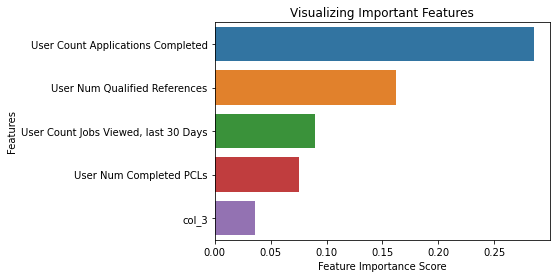

In [23]:
feature_importances = sorted(zip(features_xgb,list(X.columns)), reverse = True)[:5]; feature_importances
# Plotting Feature Importances
feature_imp = [item[0] for item in feature_importances]
feature_imp_index = [item[1] for item in feature_importances]
sns.barplot(x=feature_imp, y=feature_imp_index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

*Prediction & Accuracy. <br> Preprocess & Scale parameters before running model predictions*

In [44]:
# make predictions for test data
y_pred = model_XGB.predict(X_test_rescaled)
accuracy = accuracy_score(y_test, y_pred)

In [45]:
accuracy

0.8465608465608465

*K-folds Cross Valiation (making sure that 85% is not too good to be true...)*

In [48]:
# Data Prep for K-folds Cross Validation
X_kfolds_rescaled = scaler.transform(X.values)
y_kfold = Y.values

In [52]:
kfold = KFold(n_splits=10, random_state=42)
results = cross_val_score(model_XGB, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 81.86% (6.07%)
